<a href="https://colab.research.google.com/github/regiiis/pv_error_classification/blob/main/pv_error_classifcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DLV Group Project - **Anomaly Classification**



# LOCAL Runtime

In [1]:
# # Using LOCAL ressources

# # 1. jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0
# os.chdir(G:/My Drive/Colab Notebooks/data)

# path = "G:/My Drive/Colab Notebooks/data/2020-02-14_InfraredSolarModules"

# CLOUD Runtime

In [2]:
# # Using CLOUD ressources and DRIVE

# # Import drive and allow access
# from google.colab import drive
# drive.mount('/content/drive')

# # Unzip data on Google Drive
# !unzip "/content/drive/My Drive/Colab Notebooks/data/2020-02-14_InfraredSolarModules.zip"

# path = "/content"


In [3]:
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#   print('Not connected to a GPU')
# else:
#   print(gpu_info)

# Set Up

## Packages

In [1]:
# General imports
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import savetxt
from numpy import genfromtxt
from numpy import expand_dims
import os, datetime
import sys
import math
import random
import json

from sklearn import preprocessing

# Import graph plotting lib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Imoprt tensorflow and set to eager execution
import tensorflow as tf
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)

# Shortcuts to keras
from tensorflow import keras
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras import Input
# Performance tools
# !pip install scikit-learn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

# NN visualisation
#!pip install visualkeras
import visualkeras
from collections import defaultdict
from PIL import ImageFont

# Histogram
from IPython.core.pylabtools import figsize
import seaborn as sns
sns.set_style("white")

## Load Data

In [2]:
# Load data into df

df = pd.read_json(r'C:\Users\ASUS\Downloads\Đồ án tốt nghiệp\2020-02-14_InfraredSolarModules\InfraredSolarModules\module_metadata.json',orient="index")
df['image_name'] = df['image_filepath'].str[7:]
df = df.sort_index()
df

,image_filepath,anomaly_class,image_name
0,images/0.jpg,Offline-Module,0.jpg
1,images/1.jpg,Offline-Module,1.jpg
2,images/2.jpg,Offline-Module,2.jpg
3,images/3.jpg,Offline-Module,3.jpg
4,images/4.jpg,Offline-Module,4.jpg
...,...,...,...
19995,images/19995.jpg,No-Anomaly,19995.jpg
19996,images/19996.jpg,No-Anomaly,19996.jpg
19997,images/19997.jpg,No-Anomaly,19997.jpg
19998,images/19998.jpg,No-Anomaly,19998.jpg


## Explore Data

In [3]:
# Display all categories

categories = df["anomaly_class"].unique()
list(categories)

['Offline-Module',
 'Diode-Multi',
 'Diode',
 'Shadowing',
 'Cell-Multi',
 'Cell',
 'Hot-Spot',
 'Cracking',
 'Hot-Spot-Multi',
 'Soiling',
 'Vegetation',
 'No-Anomaly']

In [4]:
path=r'C:\Users\ASUS\Downloads\Đồ án tốt nghiệp\2020-02-14_InfraredSolarModules'

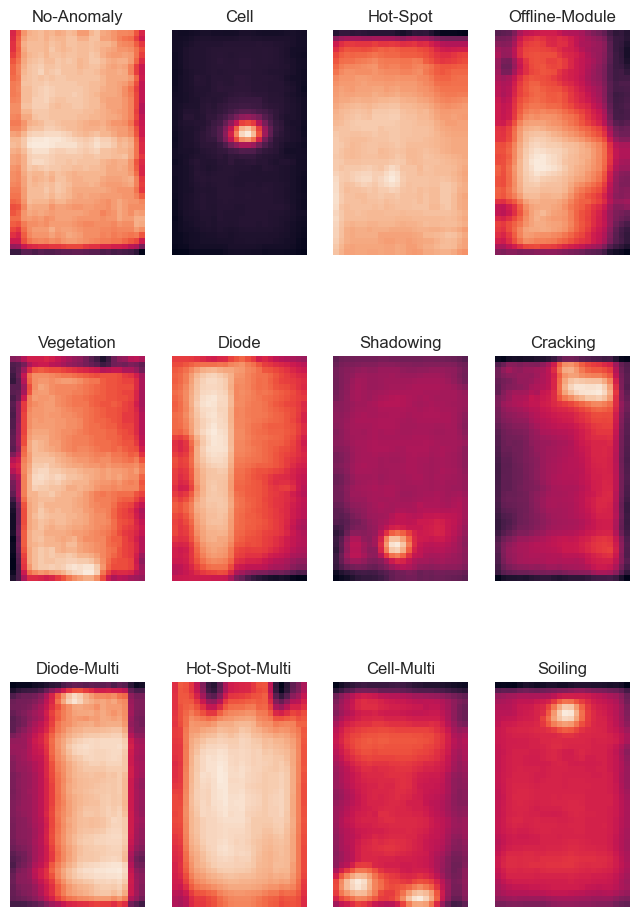

In [5]:
# Select and display a iamge for each category

df.groupby('anomaly_class').head(1)
img1 = mpimg.imread(f'{path}/InfraredSolarModules/images/13357.jpg') #No-Anomaly
img2 = mpimg.imread(f'{path}/InfraredSolarModules/images/5988.jpg')  #Cell
img3 = mpimg.imread(f'{path}/InfraredSolarModules/images/6796.jpg')  #Hot-Spot
img4 = mpimg.imread(f'{path}/InfraredSolarModules/images/270.jpg')  #Offline-Module
img5 = mpimg.imread(f'{path}/InfraredSolarModules/images/9528.jpg') #Vegetation
img6 = mpimg.imread(f'{path}/InfraredSolarModules/images/2143.jpg')  #Diode
img7 = mpimg.imread(f'{path}/InfraredSolarModules/images/3519.jpg')  #Shadowing
img8 = mpimg.imread(f'{path}/InfraredSolarModules/images/7188.jpg')  #Cracking
img9 = mpimg.imread(f'{path}/InfraredSolarModules/images/876.jpg') #Diode-Multi
img10 = mpimg.imread(f'{path}/InfraredSolarModules/images/8019.jpg')  #Hot-Spot-Multi
img11 = mpimg.imread(f'{path}/InfraredSolarModules/images/4592.jpg')  #Cell-Multi
img12 = mpimg.imread(f'{path}/InfraredSolarModules/images/8291.jpg')  #Soiling

#create list of image name
list_img = []
for i in range(12):
  list_img.append(f"img{i+1}")

# Create list of category names
list_categories = ['No-Anomaly','Cell','Hot-Spot','Offline-Module','Vegetation','Diode','Shadowing',
            'Cracking','Diode-Multi','Hot-Spot-Multi','Cell-Multi','Soiling']

# Plot images
fig = plt.figure(figsize=(8, 12))
columns = 4
rows = 3
for i,n in zip(range(1, columns*rows +1), list_categories):
    img = f"img{i}"
    fig.add_subplot(rows, columns, i)
    plt.imshow(globals()[img])
    plt.title(n)
    plt.axis('off')
plt.show()



In [6]:
# Summary Statistics

df["anomaly_class"].describe()

count          20000
unique            12
top       No-Anomaly
freq           10000
Name: anomaly_class, dtype: object

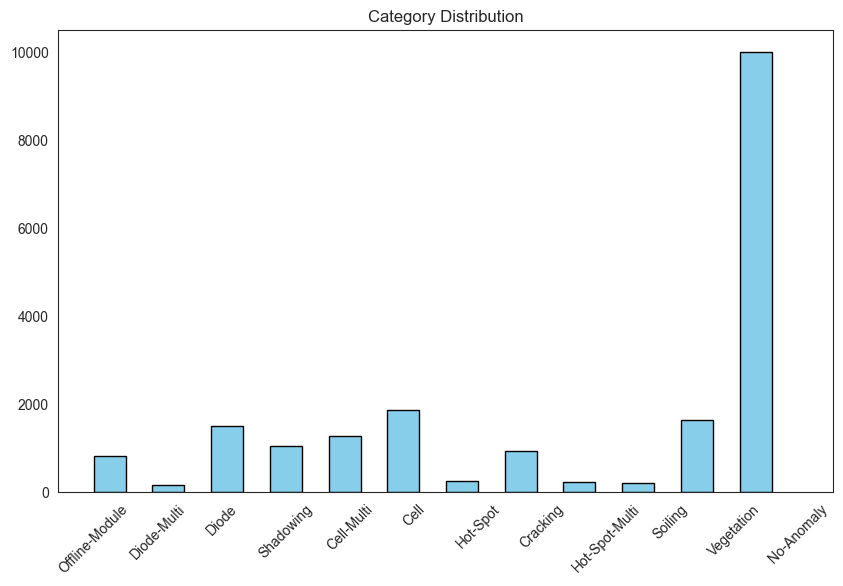

In [7]:
# Plot histogram of data

figsize(10, 6)
plt.hist(df["anomaly_class"], color='skyblue', edgecolor='black', bins = 12, width = 0.5, rwidth = 1)
plt.title('Category Distribution')
plt.xticks(rotation = 45)

plt.show()

## Create Train, Validation and Test DF

In [8]:
# Split data into df with 0.8/0.1/0.1 ratio

seed = 200

reduced_df = df.sample(frac = 1, random_state = seed) # random -> seed value
train_df = reduced_df.sample(frac = 0.8,random_state = seed)
validation_test_df = reduced_df.drop(train_df.index)
validation_df = validation_test_df.sample(frac = 0.5,random_state = seed)

test_df = validation_test_df.drop(validation_df.index)

print(train_df.info())
print(validation_df.info())

test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16000 entries, 6173 to 19483
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  16000 non-null  object
 1   anomaly_class   16000 non-null  object
 2   image_name      16000 non-null  object
dtypes: object(3)
memory usage: 500.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 11758 to 6277
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  2000 non-null   object
 1   anomaly_class   2000 non-null   object
 2   image_name      2000 non-null   object
dtypes: object(3)
memory usage: 62.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 8571 to 11343
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  2000 non-null   object
 1   anomaly_class 

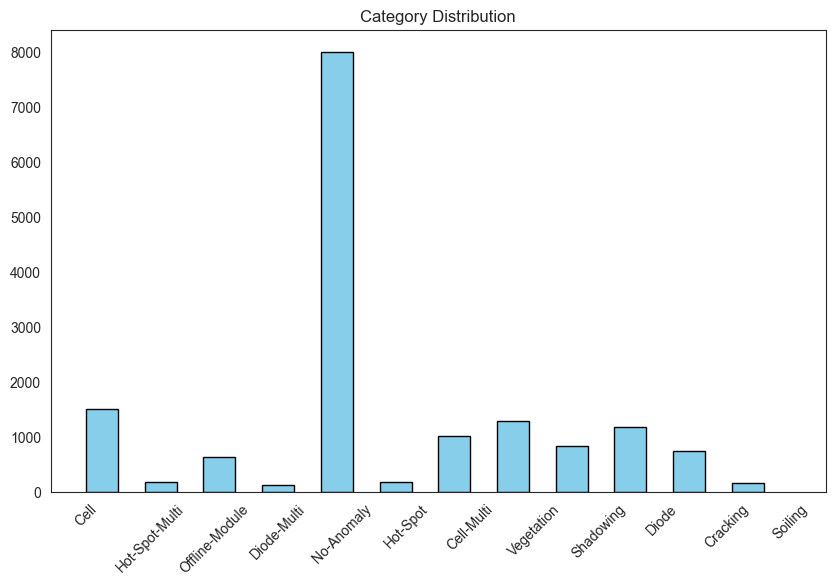

In [9]:
# Plot histogram of data

figsize(10, 6)
plt.hist(train_df["anomaly_class"], color='skyblue', edgecolor='black', bins = 12, width = 0.5, rwidth = 1)
plt.title('Category Distribution')
plt.xticks(rotation = 45)

plt.show()

In [108]:
# Set up train, validation and test generator

image_height = 40
image_width = 24
batch_size = 256



train_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe = train_df,
    directory = f'{path}/InfraredSolarModules/images/',
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    rescale=1./255,
    batch_size = batch_size,
    color_mode = "grayscale",
    shuffle = False
)

validation_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe = validation_df,
    directory = f'{path}/InfraredSolarModules/images/',
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    rescale=1./255,
    batch_size = batch_size,
    color_mode = "grayscale",
    shuffle = False
)

test_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe = test_df,
    directory = f'{path}/InfraredSolarModules/images/',
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    rescale=1./255,
    batch_size = batch_size,
    color_mode = "grayscale",
    shuffle = False
)


Found 16000 validated image filenames belonging to 12 classes.
Found 2000 validated image filenames belonging to 12 classes.
Found 2000 validated image filenames belonging to 12 classes.


# CNN Model - Basic

## Calculate Class weights

In [109]:
# Class weights
class_weight_list = compute_class_weight(class_weight = 'balanced',classes = np.unique(train_df['anomaly_class']), y = train_df['anomaly_class'])
print(class_weight_list)
print()

class_weight_rooted = [math.sqrt(n) for n in class_weight_list]

class_weight_list = preprocessing.normalize([class_weight_rooted])
print(class_weight_list)
print()

class_weights = dict(zip(np.unique(train_df['anomaly_class']), class_weight_list[0])) #[0]
print(class_weights)

class_weight_dict = {}
n = 0

for i in class_weights:
  key = str(n)
  key = int(n)
  class_weight_dict[key] = float(class_weights[i])
  n = n + 1

print()
print(class_weight_dict)


[0.88183422 1.29701686 1.7520806  1.12612613 9.52380952 6.83760684
 6.76818951 0.16647938 2.05761317 1.56311059 7.88954635 1.02249489]

[[0.14686106 0.17810905 0.20700947 0.16596125 0.48263468 0.40894532
  0.40686416 0.06381068 0.22433397 0.19552758 0.43927774 0.15814073]]

{'Cell': 0.14686105677467162, 'Cell-Multi': 0.17810905000040383, 'Cracking': 0.2070094712879631, 'Diode': 0.16596124851798494, 'Diode-Multi': 0.48263468168720725, 'Hot-Spot': 0.40894531660911776, 'Hot-Spot-Multi': 0.40686415645050494, 'No-Anomaly': 0.06381068367176822, 'Offline-Module': 0.22433396977037995, 'Shadowing': 0.19552758171551296, 'Soiling': 0.43927773583883156, 'Vegetation': 0.15814073349893937}

{0: 0.14686105677467162, 1: 0.17810905000040383, 2: 0.2070094712879631, 3: 0.16596124851798494, 4: 0.48263468168720725, 5: 0.40894531660911776, 6: 0.40686415645050494, 7: 0.06381068367176822, 8: 0.22433396977037995, 9: 0.19552758171551296, 10: 0.43927773583883156, 11: 0.15814073349893937}


## Build Model 4

In [118]:
# build the CNN

image_height = 40
image_width = 24
num_classes = 12

model_4 = Sequential()
model_4.add(Conv2D(filters = 64, kernel_size = (2,2), input_shape=(image_height, image_width, 1), activation = "relu"))
model_4.add(MaxPooling2D(pool_size= (2,2)))

model_4.add(Conv2D(filters = 128, kernel_size = (2,2), activation = "relu"))
model_4.add(MaxPooling2D(pool_size = (2,2)))

model_4.add(Conv2D(filters = 256, kernel_size = (2,2), activation = "relu"))
model_4.add(MaxPooling2D(pool_size = (2,2)))

# model_4.add(Conv2D(filters = 512, kernel_size = (2,2), activation = "relu"))
# model_4.add(MaxPooling2D(pool_size = (2,2)))

model_4.add(Flatten())
model_4.add(Dropout(0.5))

model_4.add(Dense(2048, activation="relu"))
model_4.add(Dropout(0.4))

model_4.add(Dense(1024, activation="relu"))
model_4.add(Dropout(0.3))

model_4.add(Dense(512, activation="relu"))
model_4.add(Dropout(0.2))

# model_4.add(Dense(64, activation="relu"))
# model_4.add(Dropout(0.1))
            
model_4.add(Dense(num_classes, activation='softmax'))

model_4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.AdamW(5e-5),
              metrics=['accuracy'])
model_4.build((None,image_height,image_width,1))
model_4.summary()

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 39, 23, 64)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 19, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 18, 10, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 9, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 8, 4, 256)      │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 4, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 2048)           │     4,196,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,990,028 (26.66 MB)

 Trainable params: 6,990,028 (26.66 MB)

 Non-trainable params: 0 (0.00 B)

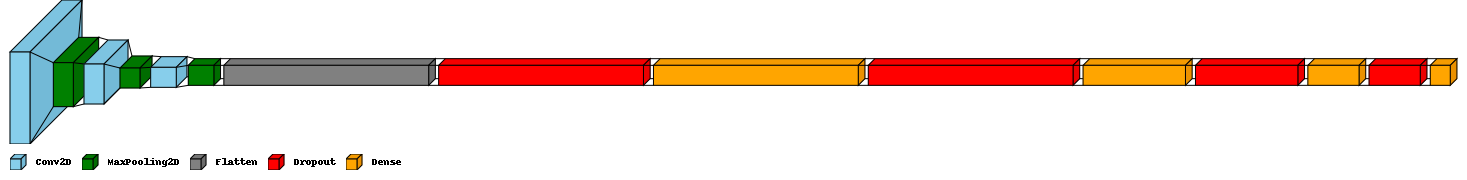

In [119]:
# Visualize Model

# visualkeras.layered_view(model_4, legend=True)

color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = 'skyblue'
color_map[layers.MaxPooling2D]['fill'] = 'green'
color_map[layers.Dropout]['fill'] = 'red'
color_map[layers.Dense]['fill'] = 'orange'
color_map[layers.Flatten]['fill'] = 'grey'
color_map[layers.Activation]['fill'] = 'yellow'
visualkeras.layered_view(model_4, legend=True, color_map=color_map)


## Train Model 4


In [120]:
history_4 = model_4.fit(
    train_generator,
    epochs = 100,
    validation_data = validation_generator,
    class_weight = class_weight_dict
 )

history_path = 'history_model_4.json'
with open(history_path, 'w') as file:
    json.dump(history_4.history, file)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.1552 - loss: 1.1376

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 370ms/step - accuracy: 0.1555 - loss: 1.1315 - val_accuracy: 0.0610 - val_loss: 2.3099
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 310ms/step - accuracy: 0.2538 - loss: 0.3483 - val_accuracy: 0.4950 - val_loss: 2.2622
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 254ms/step - accuracy: 0.3753 - loss: 0.3117 - val_accuracy: 0.5045 - val_loss: 2.1427
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 242ms/step - accuracy: 0.4639 - loss: 0.3059 - val_accuracy: 0.5170 - val_loss: 2.0273
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 293ms/step - accuracy: 0.5069 - loss: 0.2943 - val_accuracy: 0.5350 - val_loss: 1.9883
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 260ms/step - accuracy: 0.5045 - loss: 0.2880 - val_accuracy: 0.5425 - val_loss: 1.9244
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 282ms/step - accuracy: 0.5152 - loss: 0.2838 - val_accuracy: 0.5435 - val_loss: 1.8007
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - accuracy: 0.5252 - loss: 0.2802 - val_accuracy

In [131]:
model_4.save('model_4.keras')

In [20]:
model_4_loaded=keras.models.load_model('model_4.keras')

In [132]:
with open(history_path, 'r') as file:
    loaded_history_model_4 = json.load(file)

print(loaded_history_model_4["accuracy"])


[0.1704999953508377, 0.28806251287460327, 0.40843749046325684, 0.4737499952316284, 0.5034375190734863, 0.5070000290870667, 0.5169374942779541, 0.5286250114440918, 0.5418124794960022, 0.5490624904632568, 0.559374988079071, 0.5655624866485596, 0.5713750123977661, 0.5724999904632568, 0.5834375023841858, 0.5936874747276306, 0.5927500128746033, 0.5978124737739563, 0.6039999723434448, 0.6066874861717224, 0.6050000190734863, 0.6120625138282776, 0.6156250238418579, 0.617062509059906, 0.6176249980926514, 0.6201249957084656, 0.6236249804496765, 0.6306874752044678, 0.6322500109672546, 0.6305624842643738, 0.6373124718666077, 0.6389999985694885, 0.6426874995231628, 0.6414374709129333, 0.645437479019165, 0.6449375152587891, 0.651437520980835, 0.6523749828338623, 0.6528124809265137, 0.655875027179718, 0.6575624942779541, 0.6579999923706055, 0.6580625176429749, 0.6601250171661377, 0.659375011920929, 0.6606249809265137, 0.6629999876022339, 0.6681874990463257, 0.6703749895095825, 0.6686875224113464, 0.6

In [133]:
print(loaded_history_model_4.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


## Model 4 Training Performance

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15072\2108348224.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, accuracy, "bo", label = "Training accuracy", color = "skyblue")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15072\2108348224.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy",color = "orange")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15072\2108348224.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, "bo", label = "Training loss", color = "skyblue")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15072\2108348224.py:15: UserW

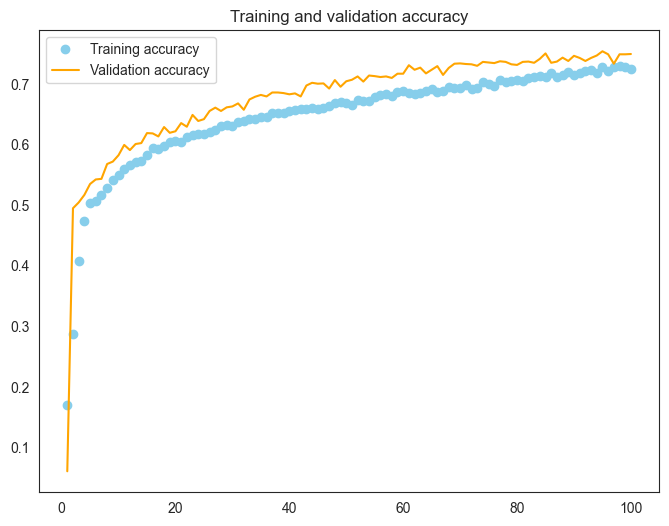

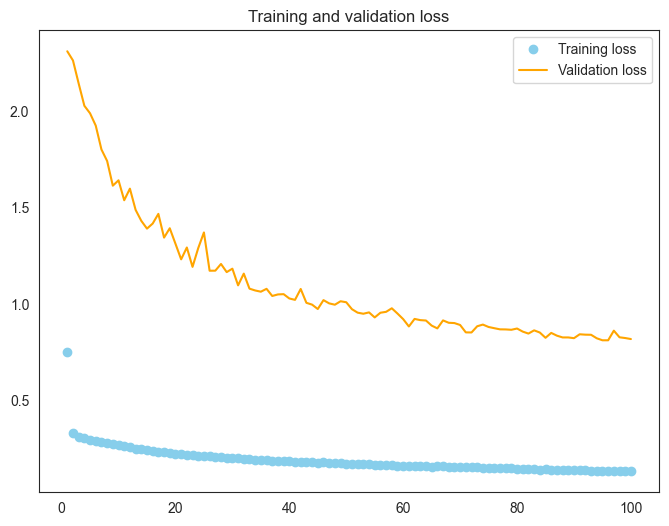

In [121]:
plt.figure(figsize = (8,6))
accuracy = history_4.history["accuracy"]
val_accuracy = history_4.history["val_accuracy"]
loss = history_4.history["loss"]
val_loss = history_4.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label = "Training accuracy", color = "skyblue")
plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy",color = "orange")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize = (8,6))
plt.plot(epochs, loss, "bo", label = "Training loss", color = "skyblue")
plt.plot(epochs, val_loss, "b", label="Validation loss", color = "orange")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [122]:
model_4.evaluate(test_generator)

1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.7070 - loss: 0.8718

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.7302 - loss: 0.8386


[0.8139401078224182, 0.7350000143051147]

In [25]:
import cv2 
from matplotlib import pyplot
for i in range(len(model_4.layers)):
    layer = model_4.layers[i]
    if 'conv' not in layer.name:
        continue
    print(i , layer.name , layer.output.shape)


# model_x = Model(inputs = model_4.inputs , outputs = model_4.layers[1].output)

image = load_img(f'{path}/InfraredSolarModules/images/5695.jpg', target_size=(40,24))
# convert the image to an array
image = img_to_array(image)
# print(image.shape)
# image = np.squeeze(image, axis=0)
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image = np.expand_dims(image, axis=-1)
# print(image.shape)
# image=cv2.resize(image,(24,40))
#  expand dimensions so that it represents a single 'sample'
image = expand_dims(image, axis=0)

# image = preprocess_input(image)

#calculating features_map
features = model_4.predict(image)

print('Anomaly Class:',categories[np.argmax(features)])
print('Actual Anomaly:',test_df[test_df.index=='5695']['anomaly_class'].name)

0 conv2d (None, 39, 23, 64)
2 conv2d_1 (None, 18, 10, 128)
4 conv2d_2 (None, 8, 4, 256)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Anomaly Class: Offline-Module
Actual Anomaly: anomaly_class


## Confusion Matrix

In [125]:
x = list(train_generator.class_indices.keys())
num_of_test_samples = 2000

Y_pred = model_4.predict(test_generator, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print()
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

print()
print('Classification Report')
target_names = x
print(classification_report(test_generator.classes, y_pred, target_names = target_names))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step

Confusion Matrix
[[ 88  19   8   0   1   4   1  26   1   2   9  23]
 [ 20  39  35   2   3   1   0  17   2   4   3  15]
 [  3   8  57   1   0   1   4   3   0   3   2   3]
 [  0   0   0 135   4   0   0  10   0   0   0   0]
 [  0   0   0   1  16   0   0   1   0   0   0   0]
 [  0   0   0   1   0  13   0   9   0   2   0   0]
 [  0   0   0   0   2   4  14   5   0   1   0   0]
 [  6   1   0   9   1   0   8 957  16  15   1   3]
 [  0   1   1   0   1   0   0  61  29   0   0   0]
 [  0   1   3   1   0   2   6  37   0  45   2   1]
 [  4   1   2   0   0   0   2   1   0   1   4   0]
 [ 32   7   5   1   0   0   0  24   1   4   4  73]]

Classification Report
                precision    recall  f1-score   support

          Cell       0.58      0.48      0.53       182
    Cell-Multi       0.51      0.28      0.36       141
      Cracking       0.51      0.67      0.58        85
         Diode       0.89      0.91      0.90       149
   Diode-Multi       0.57  

478.5


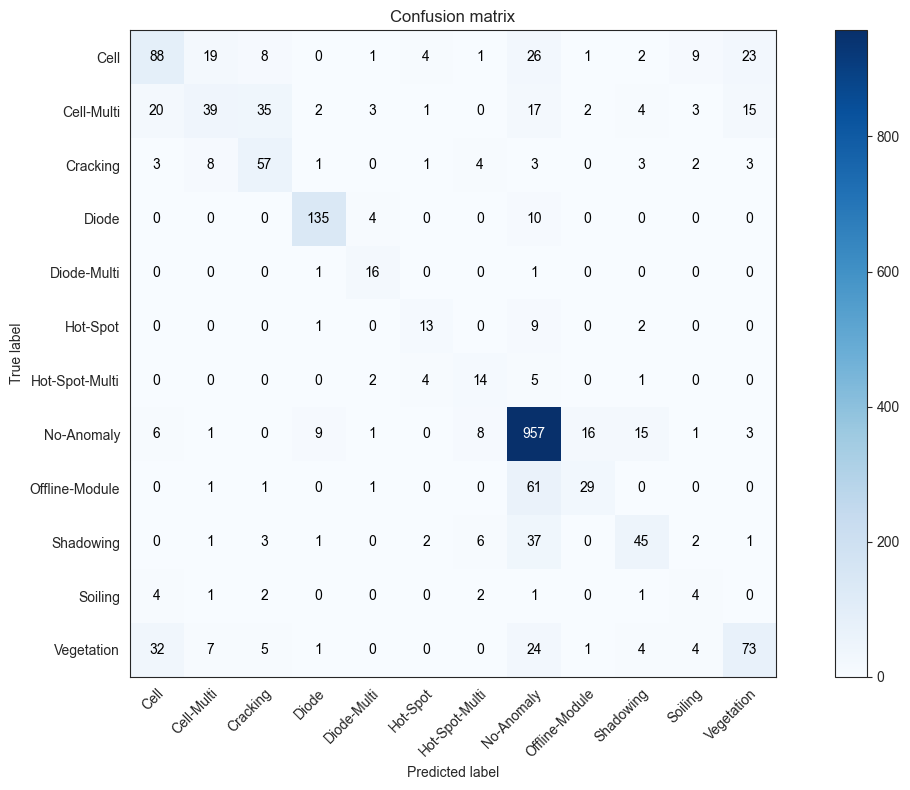

In [130]:
cm = confusion_matrix(test_generator.classes, y_pred)
fig, ax = plt.subplots(figsize = (12,8))
im = ax.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
title = 'Confusion matrix'
ax.figure.colorbar(im, ax = ax)
ax.set(xticks = np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels = target_names, yticklabels = target_names,
    title=title,
    ylabel ='True label',
    xlabel ='Predicted label',
    )
plt.setp(ax.get_xticklabels(), rotation=45, ha = "right",
             rotation_mode = "anchor")
# np.set_printoptions(precision = 2)
# plt.show()

thresh = cm.max() / 2.
print(thresh)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i, j]}",
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                )

fig.tight_layout()
plt.show()


# CNN Model - Binary-Category Model

## Create Train, Validation and Test DF

In [14]:
df_bin = df
df_bin['anomaly_class'] = np.where((df_bin['anomaly_class'] != 'No-Anomaly'),'Anomaly',df_bin['anomaly_class'])
df_bin

,image_filepath,anomaly_class,image_name
0,images/0.jpg,Anomaly,0.jpg
1,images/1.jpg,Anomaly,1.jpg
2,images/2.jpg,Anomaly,2.jpg
3,images/3.jpg,Anomaly,3.jpg
4,images/4.jpg,Anomaly,4.jpg
...,...,...,...
19995,images/19995.jpg,No-Anomaly,19995.jpg
19996,images/19996.jpg,No-Anomaly,19996.jpg
19997,images/19997.jpg,No-Anomaly,19997.jpg
19998,images/19998.jpg,No-Anomaly,19998.jpg


In [15]:
# Split data into df with 0.8/0.1/0.1 ratio

reduced_df_bin = df_bin.sample(frac = 1, random_state = 200) # random -> seed value
train_df_bin = reduced_df_bin.sample(frac = 0.8, random_state = 200)
validation_test_df_bin = reduced_df_bin.drop(train_df_bin.index)
validation_df_bin = validation_test_df_bin.sample(frac = 0.5, random_state = 200)

test_df_bin=validation_test_df_bin.drop(validation_df_bin.index)

print(train_df_bin.info())
print(validation_df_bin.info())

test_df_bin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16000 entries, 6173 to 19483
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  16000 non-null  object
 1   anomaly_class   16000 non-null  object
 2   image_name      16000 non-null  object
dtypes: object(3)
memory usage: 500.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 11758 to 6277
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  2000 non-null   object
 1   anomaly_class   2000 non-null   object
 2   image_name      2000 non-null   object
dtypes: object(3)
memory usage: 62.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 8571 to 11343
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  2000 non-null   object
 1   anomaly_class 

In [16]:
# Set up train, validation and test generator

image_height = 40
image_width = 24
batch_size = 96


train_generator_bin = ImageDataGenerator().flow_from_dataframe(
    dataframe = train_df_bin,
    directory = f'{path}/InfraredSolarModules/images/',
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    rescale = 1./255,
    batch_size = batch_size,
    color_mode = "grayscale",
    shuffle = False
)

validation_generator_bin = ImageDataGenerator().flow_from_dataframe(
    dataframe = validation_df_bin,
    directory = f'{path}/InfraredSolarModules/images/',
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    rescale = 1./255,
    batch_size = batch_size,
    color_mode = "grayscale",
    shuffle = False
)

test_generator_bin = ImageDataGenerator().flow_from_dataframe(
    dataframe = test_df_bin,
    directory = f'{path}/InfraredSolarModules/images/',
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    rescale = 1./255,
    batch_size = batch_size,
    color_mode = "grayscale",
    shuffle = False
)


Found 16000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [17]:
images, labels = next(train_generator_bin)

In [18]:
single_image = images[0]
single_label = labels[0]

print("Single image shape:", single_image.shape)
print("Single label:", single_label)

Single image shape: (40, 24, 1)
Single label: [1. 0.]


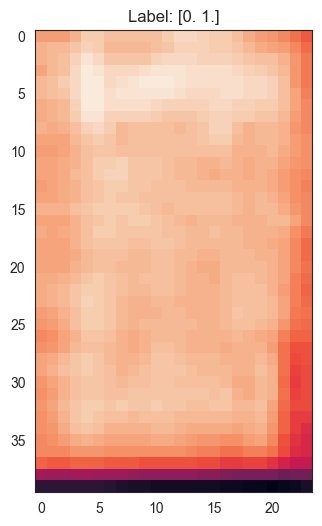

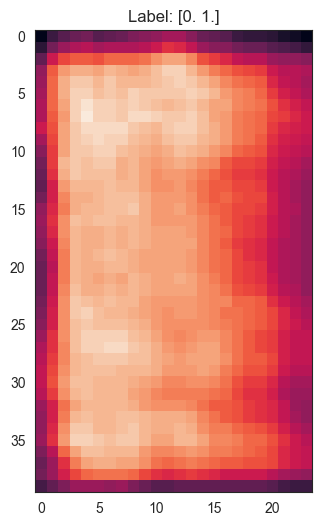

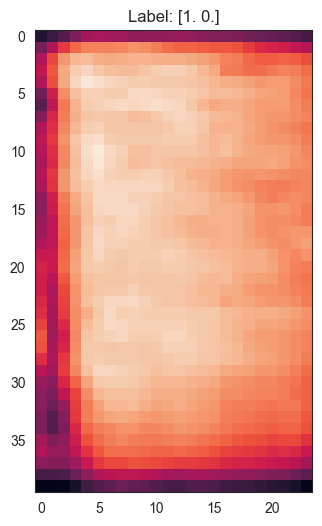

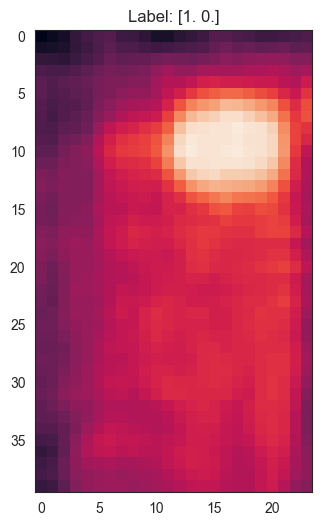

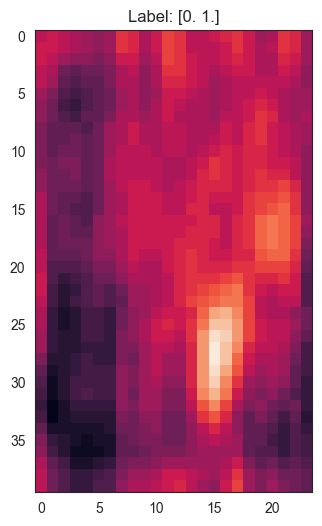

In [19]:
# Function to visualize images
def visualize_image(generator):
    images, labels = next(generator)
    for i in range(min(5, len(images))):  # Display a few images
        image = images[i]
        label = labels[i]
        plt.figure()
        plt.imshow(image.astype(np.uint8))
        plt.title(f"Label: {label}")
        plt.show()

# Visualize images from the training generator
visualize_image(train_generator_bin)

In [20]:
test_generator_bin.class_indices

{'Anomaly': 0, 'No-Anomaly': 1}

## Build Model Bin

In [21]:
# build the CNN

image_height = 40
image_width = 24
num_classes = 2

model_bin = Sequential()
model_bin.add(Conv2D(filters = 64, kernel_size = (2,2), input_shape=(image_height, image_width, 1), activation = "relu"))
model_bin.add(MaxPooling2D(pool_size = (2,2)))

model_bin.add(Conv2D(filters = 128, kernel_size = (2,2), activation = "relu"))
model_bin.add(MaxPooling2D(pool_size = (2,2)))

model_bin.add(Conv2D(filters = 256, kernel_size = (2,2), activation = "relu"))
model_bin.add(MaxPooling2D(pool_size = (2,2)))

model_bin.add(Flatten())
model_bin.add(Dropout(0.4))

model_bin.add(Dense(512, activation="relu"))
model_bin.add(Dropout(0.3))

model_bin.add(Dense(256, activation="relu"))
model_bin.add(Dropout(0.2))

model_bin.add(Dense(128, activation="relu"))

model_bin.add(Dense(2, activation='sigmoid'))

model_bin.compile(loss = 'BinaryCrossentropy', #BinaryCrossentropy
              optimizer = tf.keras.optimizers.Adam(1e-3),
              metrics = ['accuracy'])
model_bin.summary()

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 39, 23, 64)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 19, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 18, 10, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 9, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 4, 256)      │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378,114 (5.26 MB)

 Trainable params: 1,378,114 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

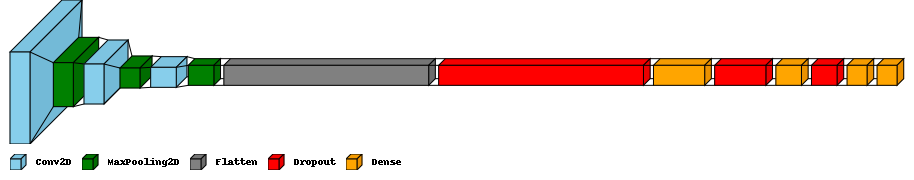

In [22]:
# Visualize Model

visualkeras.layered_view(model_bin, legend = True,)

color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = 'skyblue'
color_map[layers.MaxPooling2D]['fill'] = 'green'
color_map[layers.Dropout]['fill'] = 'red'
color_map[layers.Dense]['fill'] = 'orange'
color_map[layers.Flatten]['fill'] = 'grey'
color_map[layers.Activation]['fill'] = 'yellow'
visualkeras.layered_view(model_bin, legend = True, color_map = color_map)

## Train Model Bin

In [74]:
history_bin = model_bin.fit(
    train_generator_bin,
    epochs = 50,
    validation_data = validation_generator_bin
 )


Epoch 1/50


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


167/167 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.5154 - loss: 1.2998 - val_accuracy: 0.5130 - val_loss: 0.7515
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 13s 79ms/step - accuracy: 0.5316 - loss: 0.6936 - val_accuracy: 0.5410 - val_loss: 0.6795
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.5923 - loss: 0.6621 - val_accuracy: 0.4875 - val_loss: 0.6929
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.5754 - loss: 0.6755 - val_accuracy: 0.6930 - val_loss: 0.6336
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - accuracy: 0.6287 - loss: 0.6379 - val_accuracy: 0.6485 - val_loss: 0.6345
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 12s 72ms/step - accuracy: 0.6888 - loss: 0.5722 - val_accuracy: 0.7610 - val_loss: 0.4857
Epoch 7/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.7656 - loss: 0.4897 - val_accuracy: 0.7570 - val_loss: 0.4790
Epoch 8/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.7828 - loss: 0.4588 - val_accura

In [45]:
history_path_bin = 'history_model_bin.json'

In [78]:

with open(history_path_bin, 'w') as file:
    json.dump(history_bin.history, file)
model_bin.save("model_bin.keras")

In [46]:
with open(history_path_bin, 'r') as file:
    loaded_history_model_bin = json.load(file)

print(loaded_history_model_bin.keys())


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [47]:
history_bin=loaded_history_model_bin

In [51]:
model_bin=tf.keras.models.load_model("model_bin.keras")

## Model Bin Training Performance

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15072\2788365539.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, accuracy, "bo", label = "Training accuracy", color = "skyblue")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15072\2788365539.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy", color = "orange")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15072\2788365539.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, "bo", label = "Training loss", color = "skyblue")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15072\2788365539.py:15: User

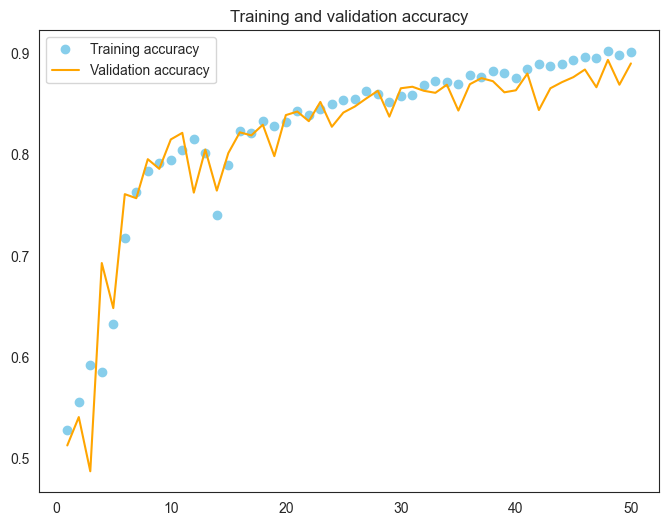

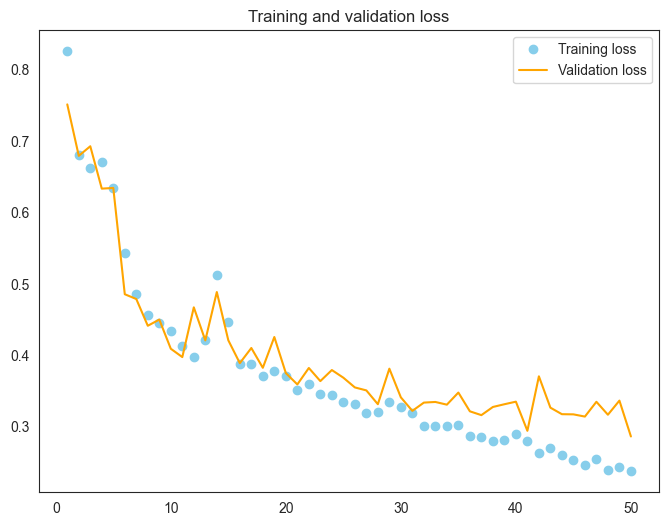

In [49]:
plt.figure(figsize = (8,6))
accuracy = history_bin["accuracy"]
val_accuracy = history_bin["val_accuracy"]
loss = history_bin["loss"]
val_loss = history_bin["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label = "Training accuracy", color = "skyblue")
plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy", color = "orange")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize = (8,6))
plt.plot(epochs, loss, "bo", label = "Training loss", color = "skyblue")
plt.plot(epochs, val_loss, "b", label = "Validation loss", color = "orange")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [47]:
image = load_img(f'{path}/InfraredSolarModules/images/9797.jpg', target_size=(40,24))
# convert the image to an array
image = img_to_array(image)
# print(image.shape)
# image = np.squeeze(image, axis=0)
image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image = np.expand_dims(image, axis=-1)
# print(image.shape)
# image=cv2.resize(image,(24,40))
#  expand dimensions so that it represents a single 'sample'
image = expand_dims(image, axis=0)

# image = preprocess_input(image)

#calculating features_map
features = model_bin.predict(image)

print(' Anomaly:0, No-Anomaly:1 :',np.argmax(features))
print('Actual Anomaly:',test_df_bin.loc[9797,'anomaly_class'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 Anomaly:0, No-Anomaly:1 : 0
Actual Anomaly: Anomaly


In [80]:
model_bin.evaluate(test_generator_bin)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8860 - loss: 0.2970


[0.30133458971977234, 0.8889999985694885]

## Confusion Matrix

In [52]:
x = list(train_generator_bin.class_indices.keys())
num_of_test_samples = 2000

Y_pred = model_bin.predict(test_generator_bin, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis = 1)
print()
print('Confusion Matrix')
print(confusion_matrix(test_generator_bin.classes, y_pred))

print()
print('Classification Report')
target_names = x
print(classification_report(test_generator_bin.classes, y_pred, target_names = target_names))

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step

Confusion Matrix
[[805 178]
 [ 44 973]]

Classification Report
              precision    recall  f1-score   support

     Anomaly       0.95      0.82      0.88       983
  No-Anomaly       0.85      0.96      0.90      1017

    accuracy                           0.89      2000
   macro avg       0.90      0.89      0.89      2000
weighted avg       0.90      0.89      0.89      2000



486.5


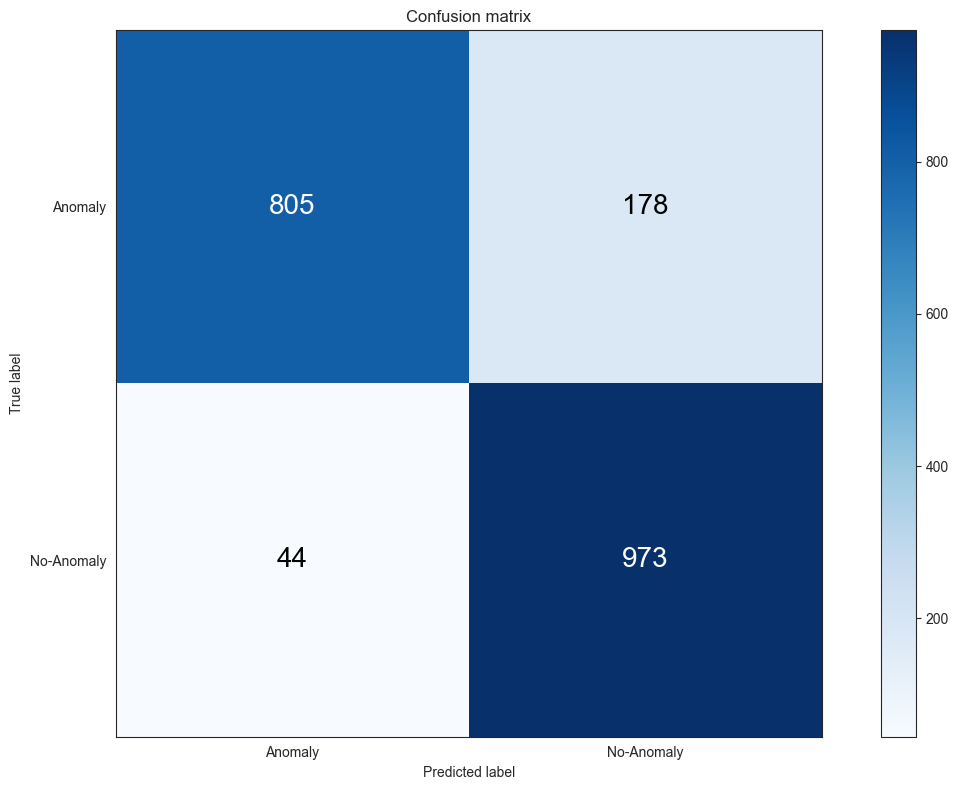

In [53]:
cm = confusion_matrix(test_generator_bin.classes, y_pred)
fig, ax = plt.subplots(figsize = (12,8))
im = ax.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
title = 'Confusion matrix'
ax.figure.colorbar(im, ax = ax)
ax.set(xticks = np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels = target_names, yticklabels = target_names,
    title = title,
    ylabel ='True label',
    xlabel ='Predicted label',
    )
thresh = cm.max() / 2.
print(thresh)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i, j]}",
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=20)

fig.tight_layout()
plt.show()

# EfficientV2B3

In [23]:
batch_size = 96


In [24]:
import numpy as np

def pad_to_square(image):
    old_size = image.shape[:2]  # Get the current shape of the image
    desired_size = max(old_size)  # Determine the size of the square to pad to
    
    # Calculate padding widths
    padding_height = (desired_size - old_size[0]) // 2
    padding_width = (desired_size - old_size[1]) // 2
    
    # Determine padding for top, bottom, left, and right
    pad_top = padding_height
    pad_bottom = desired_size - old_size[0] - pad_top
    pad_left = padding_width
    pad_right = desired_size - old_size[1] - pad_left
    
    if len(image.shape) == 2:  # Grayscale image
        # Pad the image with constant value 110
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0)
        padded_image = np.stack([padded_image] * 3, axis=-1)
    elif len(image.shape) == 3:  # Color image
        # Pad the image with constant value 110 for each channel
        padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode='constant', constant_values=0)
    else:
        raise ValueError("Unsupported image shape. Expected 2D grayscale or 3D color image.")
    
    return padded_image



In [38]:
image = mpimg.imread(r'C:\Users\ASUS\Downloads\Đồ án tốt nghiệp\images\9797.jpg')

In [40]:
image_array = img_to_array(image)
image_array=image_array.astype(int)
image_array.shape

(40, 24, 1)

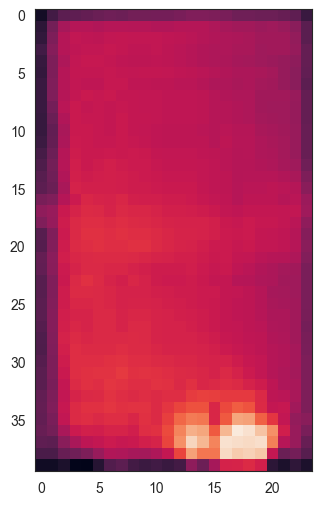

In [41]:
plt.imshow(image_array)

In [42]:
img13=pad_to_square(image_array)

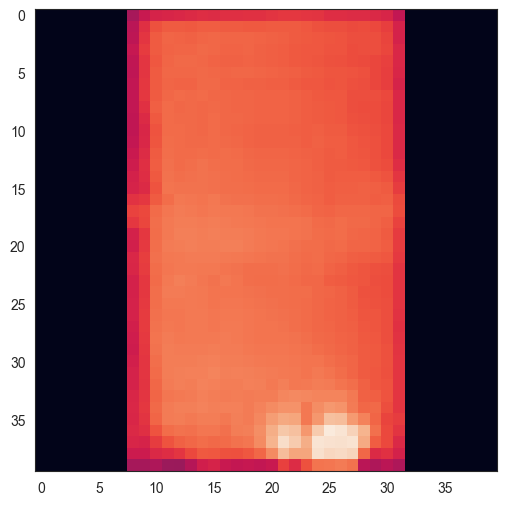

In [43]:
plt.imshow(img13)

In [60]:
from tensorflow.keras.utils import Sequence
class CustomDataGenerator(ImageDataGenerator):
    def __init__(self, preprocessing_function=None, **kwargs):
        super().__init__(preprocessing_function=preprocessing_function,**kwargs)
        self.preprocessing_function = preprocessing_function

    def flow_from_dataframe(self, dataframe, directory, x_col, y_col, batch_size, shuffle ,class_mode,color_mode, **kwargs):
        # Override flow_from_dataframe to dynamically adjust target size
        return CustomDataFrameIterator(
            dataframe=dataframe,
            directory=directory,
            image_data_generator=self,
            x_col=x_col,
            y_col=y_col,
            batch_size=batch_size,
            shuffle=shuffle,
            preprocessing_function=self.preprocessing_function,
            class_mode=class_mode,
            color_mode=color_mode,
            **kwargs
        )
    
class CustomDataFrameIterator(Sequence):
    def __init__(self, dataframe, directory, image_data_generator, x_col, y_col, batch_size, shuffle, color_mode, class_mode,preprocessing_function,**kwargs):
        self.dataframe = dataframe
        self.directory = directory
        self.x_col = x_col
        self.y_col = y_col
        self.image_data_generator=image_data_generator
        self.batch_size = batch_size
        self.color_mode = color_mode
        self.class_mode = class_mode
        self.preprocessing_function=preprocessing_function
        self.shuffle = shuffle
        self.class_indices = {class_name: idx for idx, class_name in enumerate(self.dataframe[self.y_col].unique())}
        self.indexes = np.arange(len(self.dataframe))
        self.kwargs=kwargs
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # batch = [self.dataframe.iloc[i] for i in batch_indexes]
        batch = self.dataframe.iloc[batch_indexes]
        
        images = []
        labels = []
        for _, item in batch.iterrows():
            img_path = os.path.join(self.directory, item[self.x_col])
            image = load_img(img_path, color_mode=self.color_mode)
            image = img_to_array(image)
            if self.preprocessing_function:
                image=self.preprocessing_function(image)
            image = self.image_data_generator.standardize(image)

            images.append(image)
            labels.append(item[self.y_col])    
            # labels.append(self.class_indices[item[self.y_col]])

        images = np.array(images)
        labels=np.array(labels)
        # labels = to_categorical(np.array(labels), num_classes=len(self.class_indices))  # One-hot encode labels

        if self.class_mode == 'categorical':
            labels = pd.get_dummies(labels,dtype=float).values
        elif self.class_mode == 'binary':
            labels = np.array(labels, dtype=np.float32)
        elif self.class_mode == 'sparse':
            labels = np.array(labels, dtype=np.int32)
        elif self.class_mode is None:
            return images     
           
        return images, labels

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
    @property
    def classes(self):
        return self.dataframe[self.y_col].map(self.class_indices).values

train_generator_eff = CustomDataGenerator(preprocessing_function=pad_to_square).flow_from_dataframe(
    dataframe=train_df_bin,
    directory=f'{path}/InfraredSolarModules/images/',
    x_col='image_name',
    y_col='anomaly_class',
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)
validation_generator_eff = CustomDataGenerator(preprocessing_function=pad_to_square).flow_from_dataframe(
    dataframe=validation_df_bin,
    directory=f'{path}/InfraredSolarModules/images/',
    x_col='image_name',
    y_col='anomaly_class',
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)
test_generator_eff = CustomDataGenerator(preprocessing_function=pad_to_square).flow_from_dataframe(
    dataframe=test_df_bin,
    directory=f'{path}/InfraredSolarModules/images/',
    x_col='image_name',
    y_col='anomaly_class',
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

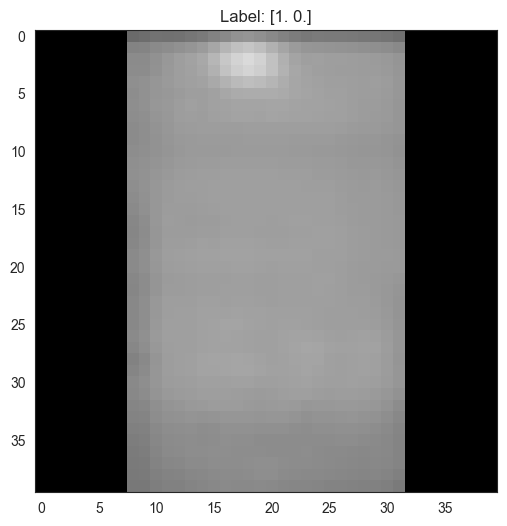

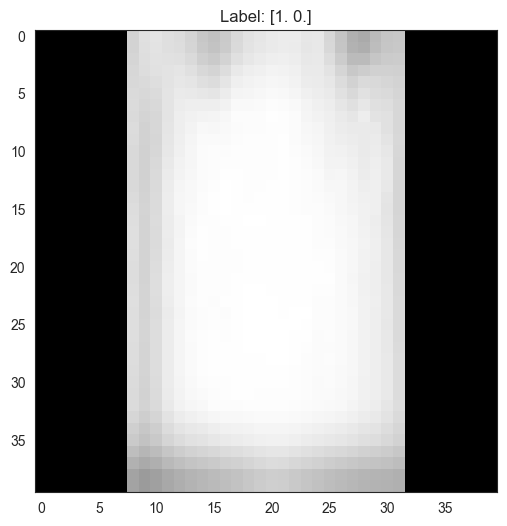

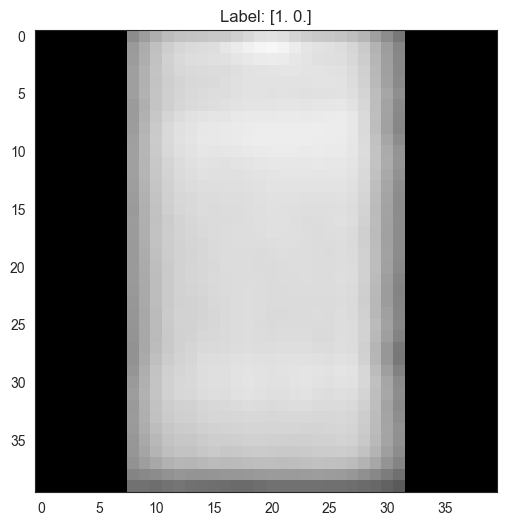

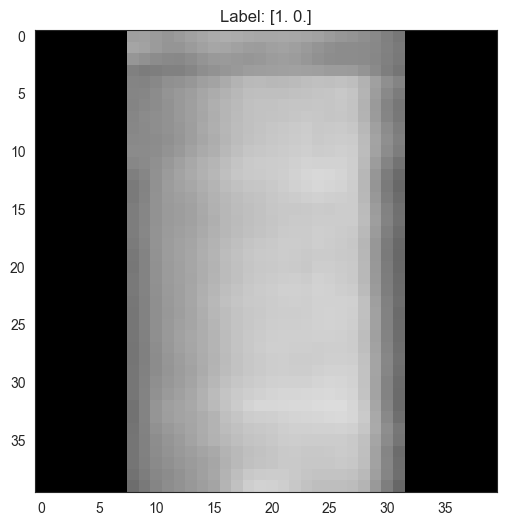

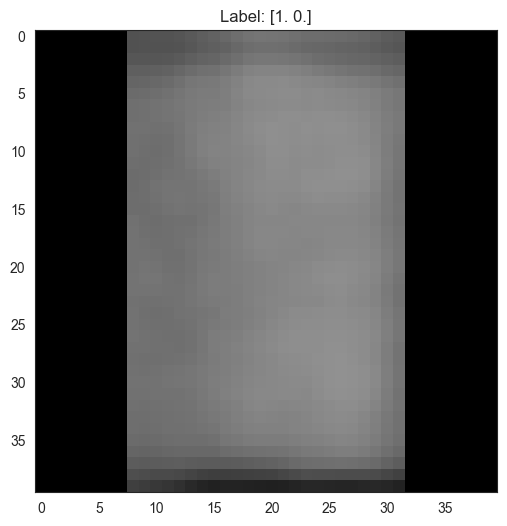

In [61]:
# Function to visualize images
def visualize_image(generator):
    images, labels = next(iter(generator))
    for i in range(min(5, len(images))):  # Display a few images
        image = images[i]
        label = labels[i]
        plt.figure()
        plt.imshow(image.astype(np.uint8))
        plt.title(f"Label: {label}")
        plt.show()

# Visualize images from the training generator
visualize_image(train_generator_eff)

In [62]:
images, labels=next(iter(train_generator_eff))
print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")

Images shape: (96, 40, 40, 3), Labels shape: (96, 2)


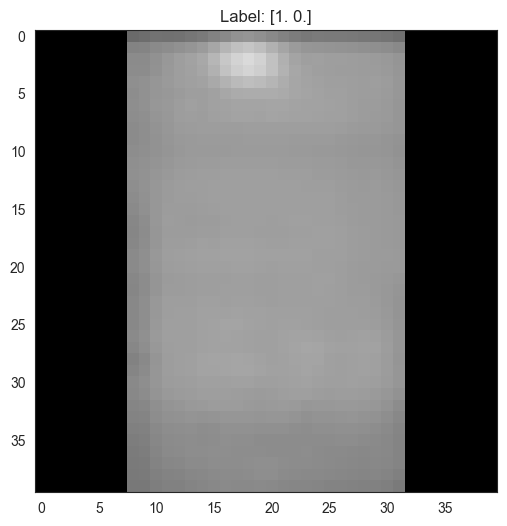

In [63]:
image=images[0]
label=labels[0]
plt.title(f"Label: {label}")
plt.imshow(image.astype(int))

In [64]:
images.shape[1:]

(40, 40, 3)

In [65]:
input_shape = images.shape[1:]

In [66]:
train_generator_eff.class_indices

{'Anomaly': 0, 'No-Anomaly': 1}

In [67]:
len(train_generator_eff.class_indices)

2

In [68]:
from tensorflow.keras.applications import EfficientNetV2B3

# local_weights_file=r'C:\Users\ASUS\Downloads\Đồ án tốt nghiệp\vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [89]:
pre_trained_model=EfficientNetV2B3(input_shape=input_shape,include_top=False,weights="imagenet")

In [90]:
for layer in pre_trained_model.layers[:-7]:
    layer.trainable=False


In [ ]:
pre_trained_model.summary()

In [97]:
from tensorflow.keras.optimizers import RMSprop, Adam
x=pre_trained_model.output
x=layers.Flatten()(x)
# x = GlobalAveragePooling2D()(x)
x=layers.Dropout(0.1)(x)
x=layers.Dense(16,activation='relu')(x)
# x=layers.Dropout(0.2)(x)
# x=layers.Dense(4,activation='relu')(x)
# x=layers.Dropout(0.1)(x)
# x=layers.Dense(8,activation='relu')(x)
# x=layers.Dropout(0.1)(x)
# x=layers.Dense(16,activation='relu')(x)
# x=layers.Dropout(0.1)(x)
x=layers.Dense(len(train_generator_eff.class_indices),activation='softmax')(x)

efficientnetV2B3_modify=Model(pre_trained_model.input,x)

efficientnetV2B3_modify.compile(optimizer=Adam(1e-3),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


In [ ]:
efficientnetV2B3_modify.summary()

In [92]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=2, restore_best_weights=True)

In [93]:
history_efficientnet = efficientnetV2B3_modify.fit(
    train_generator_eff,
    epochs = 50,
    validation_data = validation_generator_eff,
    # callbacks=[early_stopping]
 )

Epoch 1/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 71s 308ms/step - accuracy: 0.7554 - loss: 0.5113 - val_accuracy: 0.8390 - val_loss: 0.3774
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 40s 238ms/step - accuracy: 0.8160 - loss: 0.4003 - val_accuracy: 0.8380 - val_loss: 0.3728
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 40s 239ms/step - accuracy: 0.8380 - loss: 0.3675 - val_accuracy: 0.8590 - val_loss: 0.3424
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 34s 203ms/step - accuracy: 0.8504 - loss: 0.3457 - val_accuracy: 0.8615 - val_loss: 0.3281
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 33s 198ms/step - accuracy: 0.8486 - loss: 0.3464 - val_accuracy: 0.8705 - val_loss: 0.3099
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 33s 198ms/step - accuracy: 0.8585 - loss: 0.3278 - val_accuracy: 0.8630 - val_loss: 0.3196
Epoch 7/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 34s 203ms/step - accuracy: 0.8653 - loss: 0.3098 - val_accuracy: 0.8595 - val_loss: 0.3306
Epoch 8/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 34s 200ms/step - accuracy: 0.8572 - loss: 0

In [72]:
history_path_efficientNet = 'history_model_efficientNet.json'

In [66]:
with open(history_path_efficientNet, 'w') as file:
    json.dump(history_efficientnet.history, file)
    
efficientnetV2B3_modify.save('efficient_model.keras')
efficientnetV2B3_modify.save('efficient_model.h5')

In [98]:
with open(history_path_efficientNet, 'r') as file:
    loaded_history_model_efficientNet = json.load(file)

print(loaded_history_model_efficientNet.keys())


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [99]:
history_efficientnet=loaded_history_model_efficientNet

In [102]:
efficientnetV2B3_modify=tf.keras.models.load_model("efficient_model.keras")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_15072\3882634586.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, accuracy, "bo", label = "Training accuracy", color = "skyblue")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15072\3882634586.py:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy", color = "orange")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15072\3882634586.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, "bo", label = "Training loss", color = "skyblue")
C:\Users\ASUS\AppData\Local\Temp\ipykernel_15072\3882634586.py:15: User

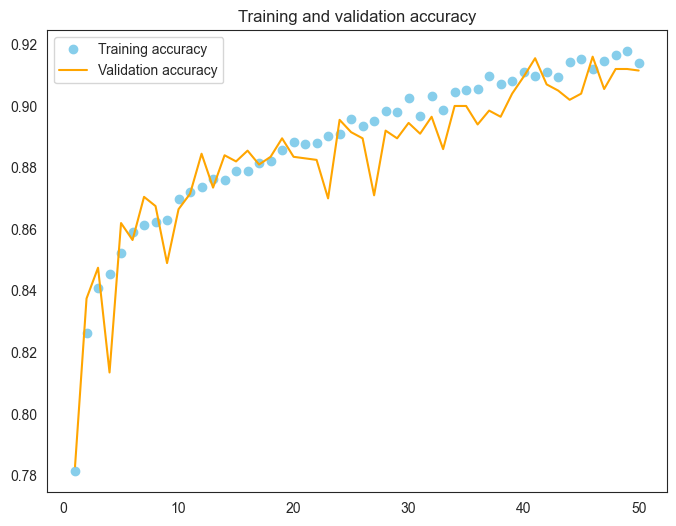

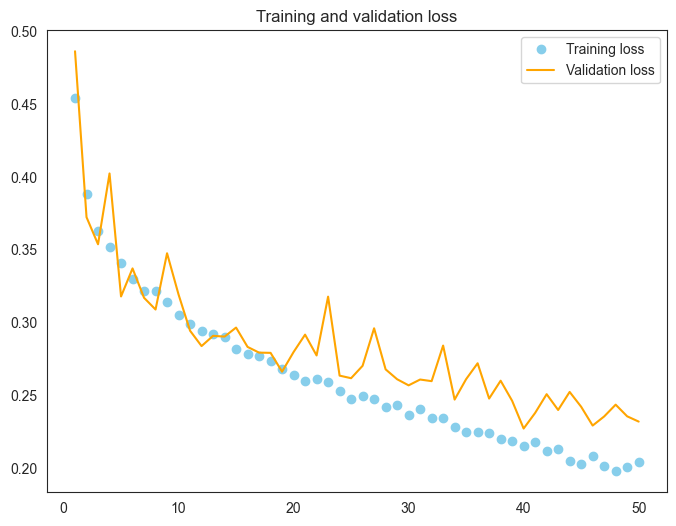

In [100]:
plt.figure(figsize = (8,6))
accuracy = history_efficientnet["accuracy"]
val_accuracy = history_efficientnet["val_accuracy"]
loss = history_efficientnet["loss"]
val_loss = history_efficientnet["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label = "Training accuracy", color = "skyblue")
plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy", color = "orange")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize = (8,6))
plt.plot(epochs, loss, "bo", label = "Training loss", color = "skyblue")
plt.plot(epochs, val_loss, "b", label = "Validation loss", color = "orange")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [103]:
x = list(train_generator_eff.class_indices.keys())
num_of_test_samples = 2000

Y_pred = efficientnetV2B3_modify.predict(test_generator_eff, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis = 1)
print()
print('Confusion Matrix')
print(confusion_matrix(test_generator_eff.classes, y_pred))

print()
print('Classification Report')
target_names = x
print(classification_report(test_generator_eff.classes, y_pred, target_names = target_names))

21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 368ms/step

Confusion Matrix
[[899  84]
 [ 79 938]]

Classification Report
              precision    recall  f1-score   support

     Anomaly       0.92      0.91      0.92       983
  No-Anomaly       0.92      0.92      0.92      1017

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



In [104]:
efficientnetV2B3_modify.evaluate(test_generator_eff)

21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - accuracy: 0.9117 - loss: 0.2373


[0.2165219783782959, 0.9185000061988831]

469.0


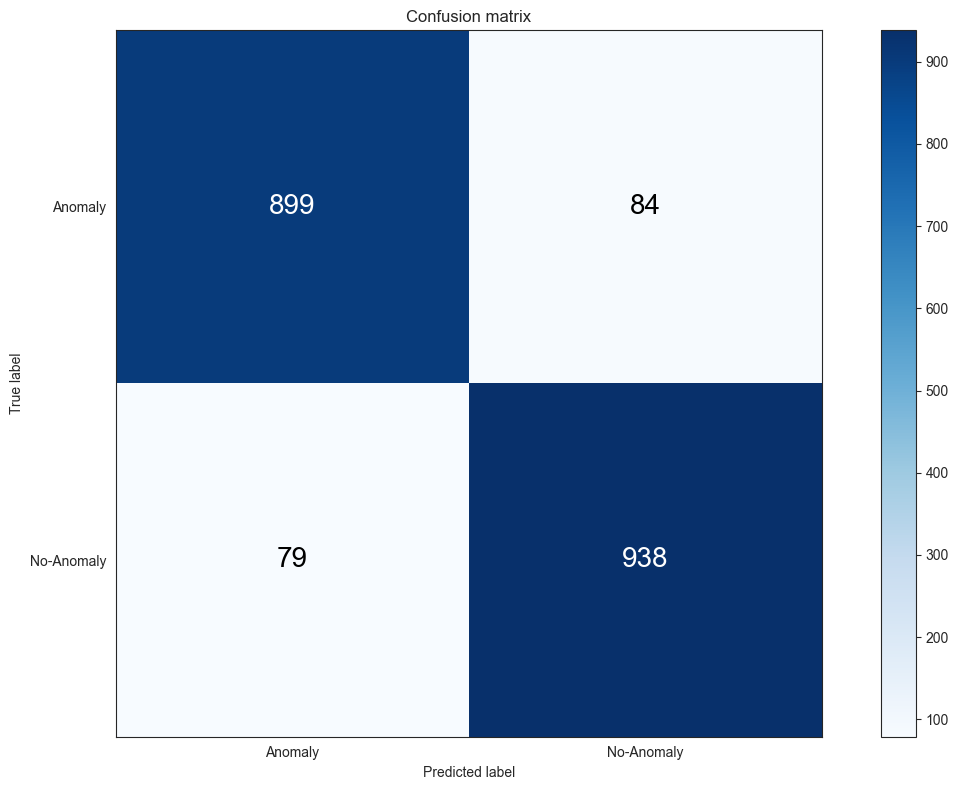

In [78]:
cm = confusion_matrix(test_generator_eff.classes, y_pred)
fig, ax = plt.subplots(figsize = (12,8))
im = ax.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
title = 'Confusion matrix'
ax.figure.colorbar(im, ax = ax)
ax.set(xticks = np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels = target_names, yticklabels = target_names,
    title = title,
    ylabel ='True label',
    xlabel ='Predicted label',
    )
thresh = cm.max() / 2.
print(thresh)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, f"{cm[i, j]}",
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
                fontsize=20)

fig.tight_layout()
plt.show()

In [51]:
model_test=tf.keras.models.load_model("model_bin.keras")

In [52]:
model_test.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 39, 23, 64)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 19, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 18, 10, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 9, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 4, 256)      │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,134,344 (15.77 MB)

 Trainable params: 1,378,114 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,756,230 (10.51 MB)

# CNN Model 7 - Anomalies Only

## Create Train, Validation and Test DF

In [ ]:
df_anomalies = df[df['anomaly_class'] != 'No-Anomaly']


In [ ]:
# Split data into df with 0.8/0.1/0.1 ratio

reduced_df_anomalies = df_anomalies.sample(frac = 1, random_state = 200) # random -> seed value
train_df_anomalies = reduced_df_anomalies.sample(frac = 0.8,random_state = 200)
validation_test_df_anomalies = reduced_df_anomalies.drop(train_df_anomalies.index)
validation_df_anomalies = validation_test_df_anomalies.sample(frac = 0.5, random_state = 200)

test_df_anomalies=validation_test_df_anomalies.drop(validation_df_anomalies.index)

print(train_df_anomalies.info())
print(validation_df_anomalies.info())

test_df_anomalies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 920 to 3079
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  8000 non-null   object
 1   anomaly_class   8000 non-null   object
 2   image_name      8000 non-null   object
dtypes: object(3)
memory usage: 250.0+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 6390 to 5811
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  1000 non-null   object
 1   anomaly_class   1000 non-null   object
 2   image_name      1000 non-null   object
dtypes: object(3)
memory usage: 31.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 8895 to 6229
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   image_filepath  1000 non-null   object
 1   anom

In [ ]:
# Set up train, validation and test generator

image_height = 40
image_width = 24
batch_size = 155


train_generator_anomalies = ImageDataGenerator().flow_from_dataframe(
    dataframe = train_df_anomalies,
    directory = f'{path}/InfraredSolarModules/images/',
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    rescale = 1./255,
    batch_size = batch_size,
    color_mode = "grayscale",
    shuffle = False
)

validation_generator_anomalies = ImageDataGenerator().flow_from_dataframe(
    dataframe = validation_df_anomalies,
    directory = f'{path}/InfraredSolarModules/images/',
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    rescale=1./255,
    batch_size = batch_size,
    color_mode = "grayscale",
    shuffle = False
)

test_generator_anomalies = ImageDataGenerator().flow_from_dataframe(
    dataframe = test_df_anomalies,
    directory = f'{path}/InfraredSolarModules/images/',
    x_col = "image_name",
    y_col = "anomaly_class",
    class_mode = "categorical",
    target_size = (image_height, image_width),
    rescale = 1./255,
    batch_size = batch_size,
    color_mode = "grayscale",
    shuffle = False
)


Found 8000 validated image filenames belonging to 11 classes.
Found 1000 validated image filenames belonging to 11 classes.
Found 1000 validated image filenames belonging to 11 classes.


## Calculate Class Weights

In [ ]:
# Class weights
class_weight_errors_list = compute_class_weight(class_weight = 'balanced',classes = np.unique(train_df_anomalies['anomaly_class']), y = train_df_anomalies['anomaly_class'])
print(class_weight_errors_list)
print()

#class_weight_errors_rooted = [math.sqrt(n) for n in class_weight_errors_list]

class_weight_errors_list = preprocessing.normalize([class_weight_errors_rooted])
print(class_weight_errors_list)
print()

class_weight_errors = dict(zip(np.unique(train_df_anomalies['anomaly_class']), class_weight_errors_list[0])) #[0]
print(class_weight_errors)

class_weight_errors_dict = {}
n = 0

for i in class_weight_errors:
  key = str(n)
  key = int(n)
  class_weight_errors_dict[key] = float(class_weight_errors[i])
  n = n + 1

print()
print(class_weight_errors_dict)


[0.49106869 0.70677622 0.94451004 0.60204696 5.12163892 3.65463682
 3.78787879 1.09859929 0.86890409 4.38116101 0.55348001]

[[0.14869282 0.17838562 0.2062159  0.16463951 0.48020132 0.40564019
  0.41296848 0.22240192 0.19779021 0.44413344 0.15785918]]

{'Cell': 0.14869281741722568, 'Cell-Multi': 0.17838561598517066, 'Cracking': 0.20621590439038953, 'Diode': 0.16463950535523994, 'Diode-Multi': 0.48020131783326797, 'Hot-Spot': 0.4056401938231437, 'Hot-Spot-Multi': 0.41296848019685123, 'Offline-Module': 0.22240191633600065, 'Shadowing': 0.19779020963544977, 'Soiling': 0.4441334421890188, 'Vegetation': 0.15785917804469174}

{0: 0.14869281741722568, 1: 0.17838561598517066, 2: 0.20621590439038953, 3: 0.16463950535523994, 4: 0.48020131783326797, 5: 0.4056401938231437, 6: 0.41296848019685123, 7: 0.22240191633600065, 8: 0.19779020963544977, 9: 0.4441334421890188, 10: 0.15785917804469174}


## Build Model 7

In [ ]:
# build the CNN

image_height = 40
image_width = 24
num_classes = 11

model_anomalies = Sequential()
model_anomalies.add(Conv2D(filters = 128, kernel_size = (2,2), input_shape=(image_height, image_width, 1), activation = "relu"))
model_anomalies.add(MaxPooling2D(pool_size= (2,2)))

model_anomalies.add(Conv2D(filters = 256, kernel_size = (2,2), activation = "relu"))
model_anomalies.add(MaxPooling2D(pool_size = (2,2)))

model_anomalies.add(Conv2D(filters = 512, kernel_size = (2,2), activation = "relu"))
model_anomalies.add(MaxPooling2D(pool_size = (2,2)))

model_anomalies.add(Flatten())

model_anomalies.add(Dense(2048, activation="relu"))
model_anomalies.add(Dropout(0.7))

model_anomalies.add(Dense(1024, activation="relu"))
model_anomalies.add(Dropout(0.4))

model_anomalies.add(Dense(512, activation="relu"))
model_anomalies.add(Dropout(0.3))

model_anomalies.add(Dense(num_classes, Activation('softmax')))


model_anomalies.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.AdamW(1e-5),
              metrics=['accuracy'])

model_anomalies.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 39, 23, 128)       640       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 19, 11, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 18, 10, 256)       131328    
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 9, 5, 256)         0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 8, 4, 512)         524800    
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 4, 2, 512)        

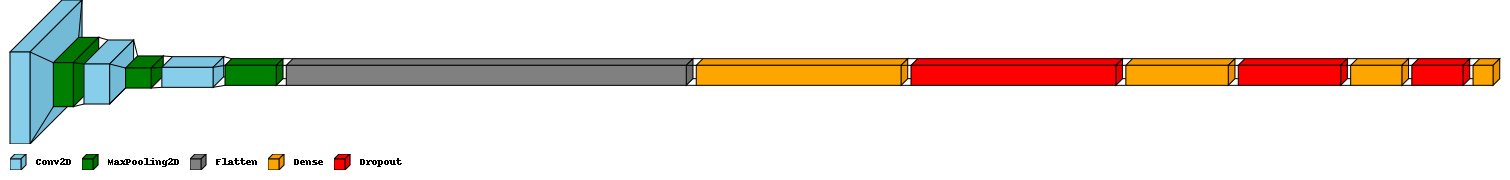

In [ ]:
# Visualize Model

visualkeras.layered_view(model_anomalies, legend=True)

color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = 'skyblue'
color_map[layers.MaxPooling2D]['fill'] = 'green'
color_map[layers.Dropout]['fill'] = 'red'
color_map[layers.Dense]['fill'] = 'orange'
color_map[layers.Flatten]['fill'] = 'grey'
color_map[layers.Activation]['fill'] = 'yellow'
visualkeras.layered_view(model_anomalies, legend=True, color_map = color_map)

## Train Model 7

In [ ]:
history_anomalies = model_anomalies.fit(
    train_generator_anomalies,
    epochs = 500,
    validation_data = validation_generator_anomalies,
    class_weight = class_weight_errors_dict
 )


Epoch 1/500
52/52 [==============================] - 9s 77ms/step - loss: 1.9198 - accuracy: 0.1075 - val_loss: 2.7656 - val_accuracy: 0.1940
Epoch 2/500
52/52 [==============================] - 2s 45ms/step - loss: 0.8898 - accuracy: 0.1240 - val_loss: 2.3266 - val_accuracy: 0.2100
Epoch 3/500
52/52 [==============================] - 2s 45ms/step - loss: 0.5898 - accuracy: 0.1265 - val_loss: 2.2592 - val_accuracy: 0.2360
Epoch 4/500
52/52 [==============================] - 3s 59ms/step - loss: 0.5070 - accuracy: 0.1355 - val_loss: 2.2638 - val_accuracy: 0.1960
Epoch 5/500
52/52 [==============================] - 2s 45ms/step - loss: 0.4788 - accuracy: 0.1513 - val_loss: 2.2275 - val_accuracy: 0.2460
Epoch 6/500
52/52 [==============================] - 2s 45ms/step - loss: 0.4685 - accuracy: 0.1635 - val_loss: 2.1954 - val_accuracy: 0.2460
Epoch 7/500
52/52 [==============================] - 2s 45ms/step - loss: 0.4624 - accuracy: 0.1752 - val_loss: 2.1929 - val_accuracy: 0.2460
Epoch 

In [ ]:
# Save model

# model_anomalies.save("/content/drive/My Drive/Colab Notebooks/models/pv_classification/model_anomalies")

## Model 7 Training Performance

<ipython-input-49-febc88b62c0c>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, accuracy, "bo", label = "Training accuracy", color = "skyblue")
<ipython-input-49-febc88b62c0c>:9: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy",color = "orange")
<ipython-input-49-febc88b62c0c>:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, "bo", label = "Training loss", color = "skyblue")
<ipython-input-49-febc88b62c0c>:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). T

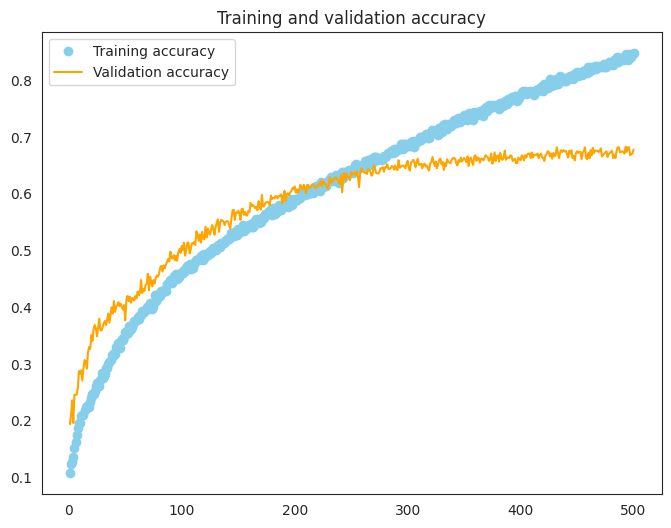

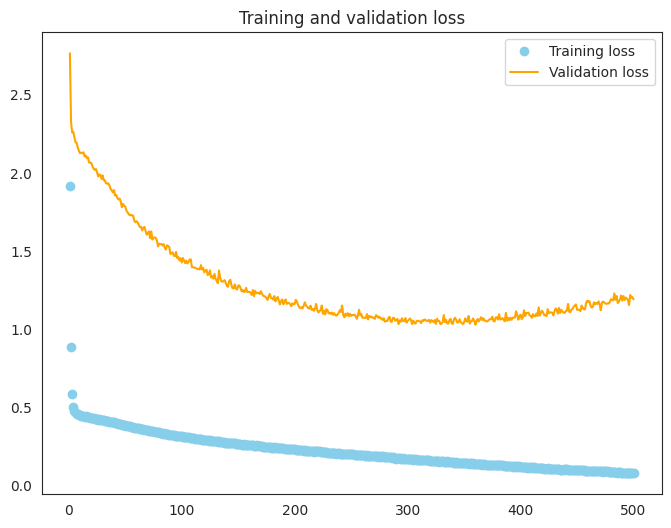

In [ ]:
plt.figure(figsize = (8,6))
accuracy = history_anomalies.history["accuracy"]
val_accuracy = history_anomalies.history["val_accuracy"]
loss = history_anomalies.history["loss"]
val_loss = history_anomalies.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "bo", label = "Training accuracy", color = "skyblue")
plt.plot(epochs, val_accuracy, "b", label = "Validation accuracy",color = "orange")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure(figsize = (8,6))
plt.plot(epochs, loss, "bo", label = "Training loss", color = "skyblue")
plt.plot(epochs, val_loss, "b", label="Validation loss", color = "orange")
plt.title("Training and validation loss")
plt.legend()

plt.show()

In [ ]:
model_anomalies.evaluate(test_generator_anomalies)

7/7 [==============================] - 0s 33ms/step - loss: 1.2290 - accuracy: 0.6710


[1.2290120124816895, 0.6710000038146973]

## Confusion Matrix

In [ ]:
x = list(train_generator_anomalies.class_indices.keys())
num_of_test_samples = 1000

Y_pred = model_anomalies.predict_generator(test_generator_anomalies, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print()
print('Confusion Matrix')
print(confusion_matrix(test_generator_anomalies.classes, y_pred))

print()
print('Classification Report')
target_names = x
print(classification_report(test_generator_anomalies.classes, y_pred, target_names = target_names))

<ipython-input-51-89d24471a2e0>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model_anomalies.predict_generator(test_generator_anomalies, num_of_test_samples // batch_size+1)



Confusion Matrix
[[120  17   9   0   0   2   0   5   7   1  29]
 [ 36  43  22   1   0   0   0   8   3   2  19]
 [  3   8  59   1   0   0   2   1   1   2   6]
 [  1   0   0 121   2   3   1   4   3   0   0]
 [  0   0   0   2  14   0   0   1   1   0   0]
 [  1   0   0   0   0  18   2   1   2   0   0]
 [  1   1   0   3   2   1  17   1   0   0   2]
 [  0   0   1   1   1   0   3  74   1   0   1]
 [  3   5   4   0   1   2   4   4  83   1   8]
 [  5   4   2   0   0   0   4   0   1   3   2]
 [ 27  10   2   0   2   1   0   8   1   0 119]]

Classification Report
                precision    recall  f1-score   support

          Cell       0.61      0.63      0.62       190
    Cell-Multi       0.49      0.32      0.39       134
      Cracking       0.60      0.71      0.65        83
         Diode       0.94      0.90      0.92       135
   Diode-Multi       0.64      0.78      0.70        18
      Hot-Spot       0.67      0.75      0.71        24
Hot-Spot-Multi       0.52      0.61      0.56   

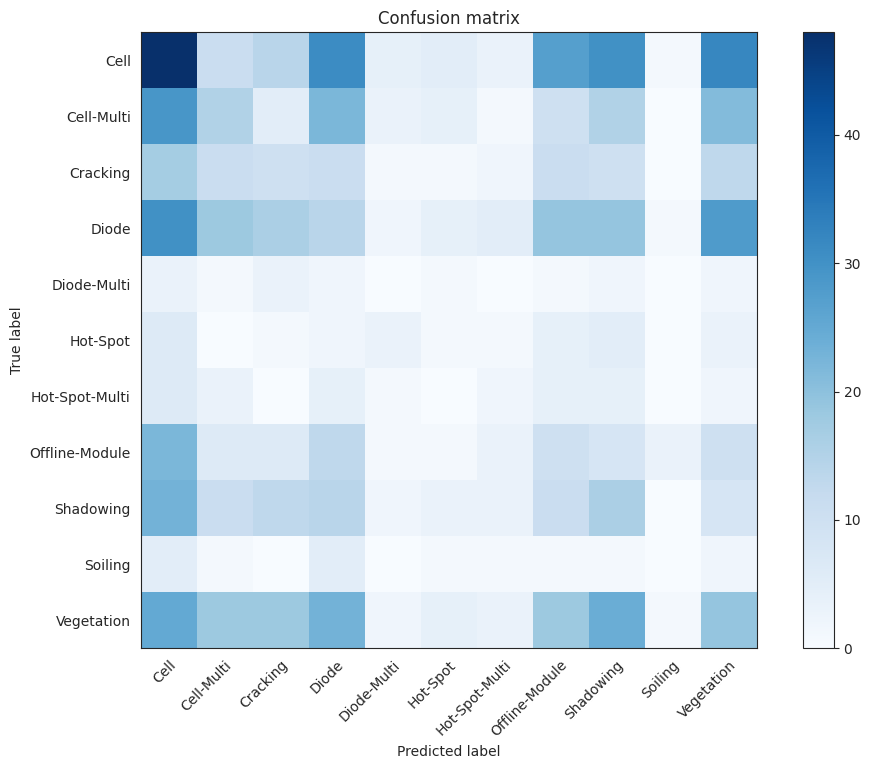

In [ ]:
cm = confusion_matrix(validation_generator_anomalies.classes, y_pred)
fig, ax = plt.subplots(figsize = (12,8))
im = ax.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Blues)
title = 'Confusion matrix'
ax.figure.colorbar(im, ax = ax)
ax.set(xticks = np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels = target_names, yticklabels = target_names,
    title=title,
    ylabel ='True label',
    xlabel ='Predicted label',
    )
plt.setp(ax.get_xticklabels(), rotation=45, ha = "right",
             rotation_mode = "anchor")
np.set_printoptions(precision = 2)
plt.show()

# Two Stages Model Algorythm

In [ ]:
# Load model binary category and anomaly only



In [ ]:
# 1. make prediction on model binary
# 2. Take anomaly classifaction and buid df

In [ ]:
# make prediction on model anomaly

In [ ]:
num_of_test_samples = 1

Y_pred = model_bin.predict_generator(test_generator_bin, num_of_test_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis = 1)